In [432]:
import numpy as np 
import pandas as pd 
import pyodbc
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

warnings.simplefilter('ignore')

In [433]:
servername = 'DESKTOP-9OVTRPL\SQLEXPRESS'

In [434]:
dwh_conn = pyodbc.connect('DRIVER={SQL SERVER};SERVER='+servername+';DATABASE=UnitedOutdoors; Trusted_Connection=yes')



In [435]:
query = "SELECT * FROM dbo.order_details"
df = pd.read_sql(query, dwh_conn)
df


,order_details_sk,order_id,product_quantity,product_listprice,order_date,shipping_date,product_productid,product_sk,employee_employeeid,employee_sk,customer_id,customer_sk,source
0,1,2001,12,9.00,1996-03-14,1996-09-15,300,582,299.0,314.0,101,92,AC
1,2,2001,12,14.00,1996-03-14,1996-09-14,301,583,299.0,314.0,101,92,AC
2,3,2001,12,14.00,1996-03-14,1996-09-14,302,584,299.0,314.0,101,92,AC
3,4,2002,24,9.00,1996-03-18,1996-09-18,400,585,467.0,321.0,102,93,AC
4,5,2002,24,10.00,1996-03-18,1996-09-18,401,586,467.0,321.0,102,93,AC
...,...,...,...,...,...,...,...,...,...,...,...,...,...
124570,124571,75122,1,21.98,2014-06-30,2014-07-07,878,383,NaN,NaN,15868,5798,AW
124571,124572,75122,1,8.99,2014-06-30,2014-07-07,712,217,NaN,NaN,15868,5798,AW
124572,124573,75123,1,21.98,2014-06-30,2014-07-07,878,383,NaN,NaN,18759,8693,AW
124573,124574,75123,1,159.00,2014-06-30,2014-07-07,879,384,NaN,NaN,18759,8693,AW


In [436]:
# # only grab the columns we need product_quantity, order_date, product_sk
df = df[['product_quantity', 'order_date']]


# # convert order_date to datetime
df['order_date'] = pd.to_datetime(df['order_date'])
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124575 entries, 0 to 124574
Data columns (total 2 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   product_quantity  124575 non-null  int64         
 1   order_date        124575 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.9 MB


In [437]:
df['order_date'] = df['order_date'].dt.to_period('M') 
monthly_sales = df.groupby('order_date').sum().reset_index()



In [438]:
monthly_sales['order_date'] = monthly_sales['order_date'].dt.to_timestamp()

In [439]:
monthly_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   order_date        73 non-null     datetime64[ns]
 1   product_quantity  73 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.3 KB


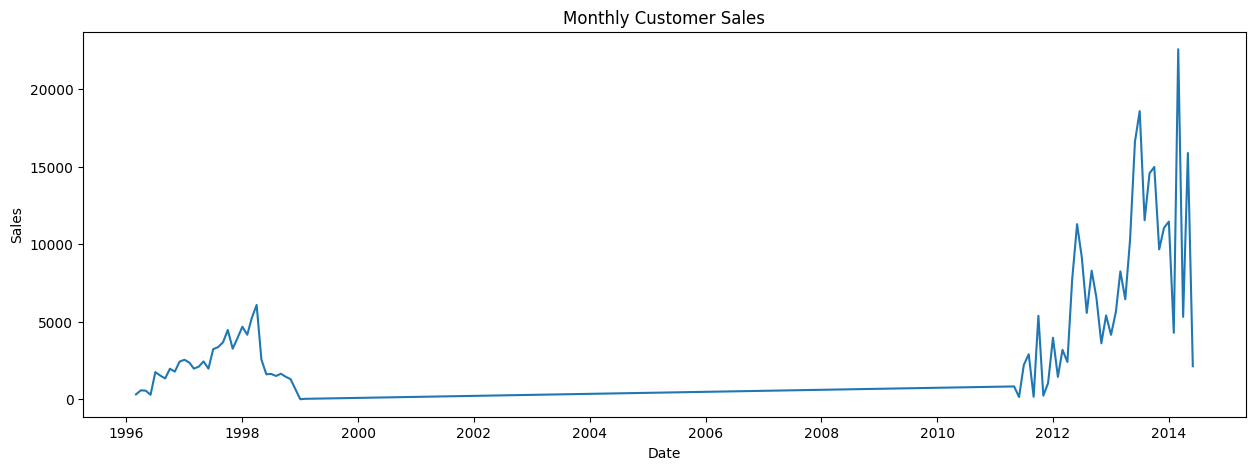

In [440]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['order_date'], monthly_sales['product_quantity'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Monthly Customer Sales')
plt.show()

In [441]:
monthly_sales['sales_diff'] = monthly_sales['product_quantity'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head(10)

,order_date,product_quantity,sales_diff
1,1996-04-01,576,264.0
2,1996-05-01,552,-24.0
3,1996-06-01,288,-264.0
4,1996-07-01,1750,1462.0
5,1996-08-01,1526,-224.0
6,1996-09-01,1340,-186.0
7,1996-10-01,1966,626.0
8,1996-11-01,1783,-183.0
9,1996-12-01,2428,645.0
10,1997-01-01,2545,117.0


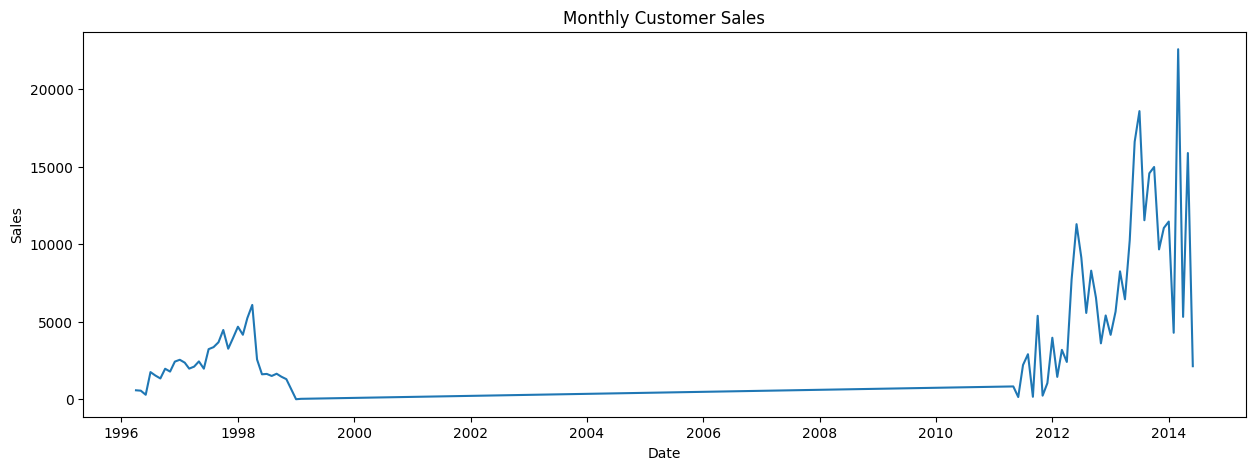

In [442]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['order_date'], monthly_sales['product_quantity'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Monthly Customer Sales')
plt.show()

In [443]:
supervised_data = monthly_sales.drop(['order_date', 'product_quantity'], axis=1)


In [444]:
for i in range(1, 13):
    col_name = 'month_' + str(i)
    supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop=True)
supervised_data.head(10)

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,130.0,-386.0,-185.0,117.0,645.0,-183.0,626.0,-186.0,-224.0,1462.0,-264.0,-24.0,264.0
1,336.0,130.0,-386.0,-185.0,117.0,645.0,-183.0,626.0,-186.0,-224.0,1462.0,-264.0,-24.0
2,-469.0,336.0,130.0,-386.0,-185.0,117.0,645.0,-183.0,626.0,-186.0,-224.0,1462.0,-264.0
3,1259.0,-469.0,336.0,130.0,-386.0,-185.0,117.0,645.0,-183.0,626.0,-186.0,-224.0,1462.0
4,131.0,1259.0,-469.0,336.0,130.0,-386.0,-185.0,117.0,645.0,-183.0,626.0,-186.0,-224.0
5,314.0,131.0,1259.0,-469.0,336.0,130.0,-386.0,-185.0,117.0,645.0,-183.0,626.0,-186.0
6,792.0,314.0,131.0,1259.0,-469.0,336.0,130.0,-386.0,-185.0,117.0,645.0,-183.0,626.0
7,-1207.0,792.0,314.0,131.0,1259.0,-469.0,336.0,130.0,-386.0,-185.0,117.0,645.0,-183.0
8,682.0,-1207.0,792.0,314.0,131.0,1259.0,-469.0,336.0,130.0,-386.0,-185.0,117.0,645.0
9,736.0,682.0,-1207.0,792.0,314.0,131.0,1259.0,-469.0,336.0,130.0,-386.0,-185.0,117.0


In [445]:
train_data = supervised_data[:-12]
test_data = supervised_data[-13:]
print("Train data shape: ", train_data.shape)
print("Test data shape: ", test_data.shape)

Train data shape:  (48, 13)
Test data shape:  (13, 13)


In [446]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [447]:
x_train, y_train = train_data[:, 1:], train_data[:, 0:1]
x_test, y_test = test_data[:, 1:], test_data[:, 0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)

x_train shape:  (48, 12)
y_train shape:  (48,)
x_test shape:  (13, 12)
y_test shape:  (13,)


In [448]:
sales_dates = monthly_sales['order_date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)

In [449]:
act_sales = monthly_sales['product_quantity'][-13:].to_list()
print(act_sales)

[16611, 18589, 11548, 14576, 14984, 9667, 11049, 11463, 4287, 22582, 5313, 15884, 2130]


In [450]:
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
lr_pred = lr_model.predict(x_test)


In [451]:
lr_pred = lr_pred.reshape(-1, 1)
lr_pred_test_set = np.concatenate((lr_pred, x_test), axis=1)
lr_pred_test_set = scaler.inverse_transform(lr_pred_test_set)

In [452]:
result_list = []
for index in range(0, len(lr_pred_test_set)):
    result_list.append(lr_pred_test_set[index][0] + act_sales[index])
lr_pred_series = pd.Series(result_list, name='Linear Prediction')
predict_df = predict_df.merge(lr_pred_series, left_index=True, right_index=True)

In [453]:
lr_mse = np.sqrt(mean_squared_error(predict_df['Linear Prediction'], monthly_sales['product_quantity'][-12:]))
lr_mae = mean_squared_error(predict_df['Linear Prediction'], monthly_sales['product_quantity'][-12:])
lr_r2 = r2_score(predict_df['Linear Prediction'], monthly_sales['product_quantity'][-12:])



print("Linear Regression MSE: ", lr_mse)
print("Linear Regression MAE: ", lr_mae)
print("Linear Regression R2: ", lr_r2)




Linear Regression MSE:  10358.424843360199
Linear Regression MAE:  107296965.23554175
Linear Regression R2:  -1.3657552163474147


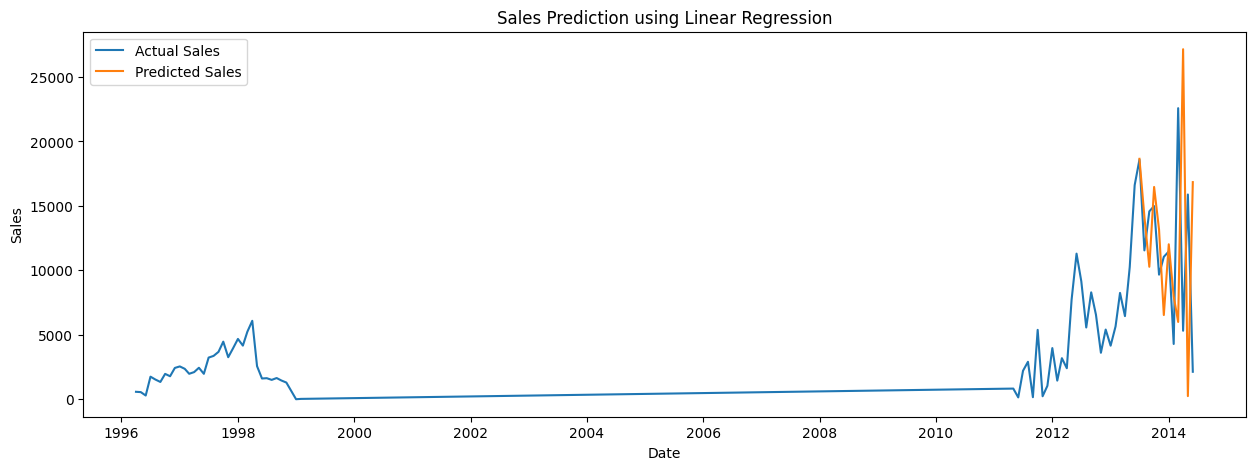

In [454]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['order_date'], monthly_sales['product_quantity'])
plt.plot(predict_df['order_date'], predict_df['Linear Prediction'])
plt.title('Sales Prediction using Linear Regression')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(['Actual Sales', 'Predicted Sales'])
plt.show()


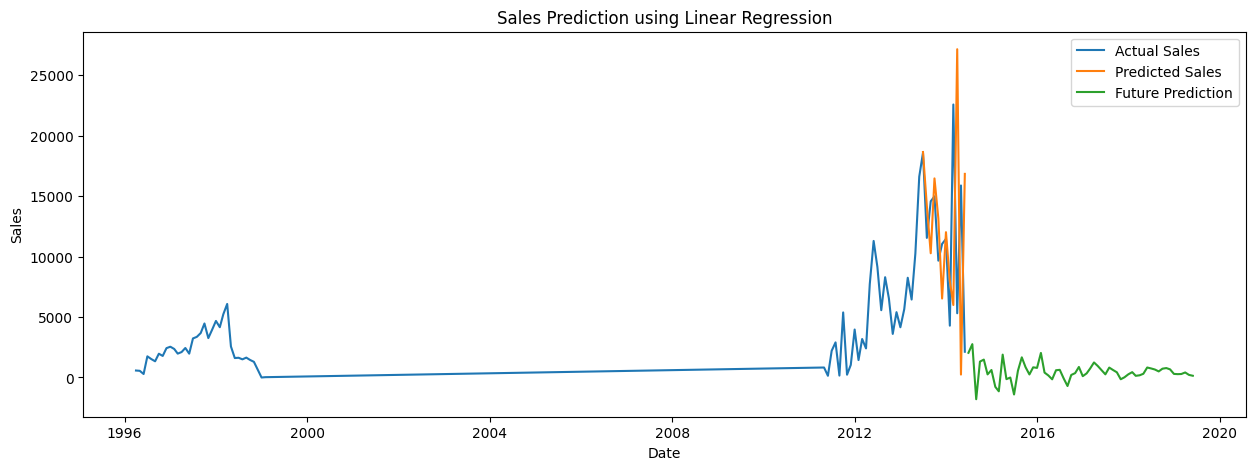

In [470]:
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)

x_future = x_train[-1, :].reshape(1, -1)

future_predictions = []

for _ in range(60):
    lr_pred = lr_model.predict(x_future)
    
    future_predictions.append(lr_pred[0])
    
    x_future = np.roll(x_future, -1)
    x_future[0, -1] = lr_pred


future_predictions = np.array(future_predictions).reshape(-1, 1)
future_predictions = np.concatenate((future_predictions, np.zeros((60, 12))), axis=1)
future_predictions = scaler.inverse_transform(future_predictions)
future_predictions = future_predictions[:, 0]

date_range = pd.date_range(start='2014-06-01', periods=60, freq='M')
future_predictions = pd.Series(future_predictions, name='Future Prediction')
future_predictions = pd.DataFrame({'order_date': date_range, 'Future Prediction': future_predictions})

plt.figure(figsize=(15,5))
plt.plot(monthly_sales['order_date'], monthly_sales['product_quantity'])
plt.plot(predict_df['order_date'], predict_df['Linear Prediction'])
plt.plot(future_predictions['order_date'], future_predictions['Future Prediction'])
plt.title('Sales Prediction using Linear Regression')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(['Actual Sales', 'Predicted Sales', 'Future Prediction'])
plt.show()
